# NIPS: Neural Information Processing Systems

Some main topics at NIPS according to [wikipedia](https://en.wikipedia.org/wiki/Conference_on_Neural_Information_Processing_Systems) :

1. Machine learning, 
2. Statistics, 
3. Artificial intelligence, 
4. Computational neuroscience

However, the topics are within the same domain which makes it more challenging to distinguish between them. Here in this Kernel I will try to extract some topics using Latent Dirichlet allocation __LDA__. This tutorial features an end-to-end natural language processing pipeline, starting with raw data and running through preparing, modeling, visualizing the paper. We'll touch on the following points

    1. Topic modeling with LDA
    2. Visualizing topic models with pyLDAvis
    3. Visualizing LDA results with t-SNE and bokeh

Note: Two major visualizations of this notebook are __interactive graphs__, which do not get loaded on the Github. To see them, go to this link: 
http://nbviewer.jupyter.org/github/ykhorram/nips2015_topic_network_analysis/blob/master/NIP15_topics_citations.ipynb

In [4]:
%pylab inline

import pandas as pd
import pickle as pk
from scipy import sparse as sp

Populating the interactive namespace from numpy and matplotlib


In [13]:
p_cit = pk.load(open('./nips_data/paper_citations_dict.pkl', 'rb'))
p_df = pd.read_csv('./nips_data/Papers.csv')

p_df['Citations'] = p_df['Title'].apply(lambda l: p_cit.get(l))
p_df['Citations'].fillna(0, inplace=True)
p_df['Citations'] = p_df['Citations'].astype(int0)


docs = array(p_df['PaperText'])

## Pre-process and vectorize the documents

In [12]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    #docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs] python3
    docs = [[lemmatizer.lemmatize(token.decode('utf-8', errors='ignore')) for token in doc] for doc in docs]

    return docs

In [14]:
docs = docs_preprocessor(docs)

### **Compute bigrams/trigrams:**
Sine topics are very similar what would make distinguish them are phrases rather than single/individual words.

In [15]:
import warnings
warnings.filterwarnings("ignore") 

In [16]:
from gensim.models import Phrases
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

### **Remove rare and common tokens:**

In [18]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))

('Number of unique words in initital documents:', 41506)
('Number of unique words after removing rare and common words:', 6068)


Pruning the common and rare words, we end up with only about 6% of the words.

** Vectorize data:**  
The first step is to get a back-of-words representation of each doc.

In [19]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [9]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 6068
Number of documents: 403


With the bag-of-words corpus, we can move on to learn our topic model from the documents.

# Train LDA model...

In [22]:
from gensim.models import LdaModel

In [34]:
# Set training parameters.
num_topics = 4
chunksize = 500 # size of the doc looked at every pass
passes = 20 # number of passes through documents
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

CPU times: user 2min 58s, sys: 1.28 s, total: 2min 59s
Wall time: 3min 2s


In [35]:
model.save('lda.model')
# later on, load trained model from file
# model =  LdaModel.load('lda.model')

 # How to choose the number of topics? 
So __LDA__ is an unsupervised technique, meaning that we don't know prior to running the model how many topics exits in our corpus. Topic coherence, is one of the main methods used to determine this. You can read about it [here.](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)

However, I used the LDA visualization tool **pyLDAvis**, tried a few number of topics and compared the resuls. Four seemed to be the optimal number of topics that would seperate  topics the most. 

In [36]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [37]:
pyLDAvis.gensim.prepare(model, corpus, dictionary)

/Users/admin/anaconda/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      27.201466        1       1  0.042022  0.014105
1      25.653688        1       2 -0.172616  0.010852
3      24.234879        1       3  0.050022 -0.107738
0      22.909967        1       4  0.080572  0.082781, topic_info=     Category         Freq                  Term        Total  loglift  \
term                                                                     
1936  Default  1169.000000                regret  1169.000000  30.0000   
3402  Default   720.000000     matrix_completion   720.000000  29.0000   
5563  Default   672.000000                bandit   672.000000  28.0000   
4232  Default   645.000000         convolutional   645.000000  27.0000   
1739  Default   689.000000           rank_matrix   689.000000  26.0000   
1227  Default   645.000000       active_learning   645.000000  25.0000   
5037  Default   571.000000            submodular   571.000000  24.0000   
5479  Default   585.000000         deep_learning   585.000000  23.0000   
316   Default   475.000000          regret_bound   475.000000  22.0000   
1796  Default   556.000000             recurrent   556.000000  21.0000   
5477  Default   521.000000      recurrent_neural   521.000000  20.0000   
2463  Default   525.000000           hidden_unit   525.000000  19.0000   
1746  Default   571.000000       fully_connected   571.000000  18.0000   
2406  Default   479.000000          hidden_layer   479.000000  17.0000   
4213  Default   621.000000           random_walk   621.000000  16.0000   
2620  Default   913.000000      gaussian_process   913.000000  15.0000   
3242  Default   461.000000                  lstm   461.000000  14.0000   
3785  Default   560.000000        singular_value   560.000000  13.0000   
3432  Default   585.000000                  item   585.000000  12.0000   
3736  Default   473.000000           line_search   473.000000  11.0000   
3137  Default   895.000000     sample_complexity   895.000000  10.0000   
5223  Default   378.000000   submodular_function   378.000000   9.0000   
1162  Default   484.000000       strongly_convex   484.000000   8.0000   
4620  Default   410.000000  convolutional_neural   410.000000   7.0000   
2247  Default   392.000000       during_training   392.000000   6.0000   
4792  Default   673.000000                tensor   673.000000   5.0000   
3628  Default   557.000000       online_learning   557.000000   4.0000   
247   Default   815.000000          markov_chain   815.000000   3.0000   
2762  Default   434.000000                 pixel   434.000000   2.0000   
4505  Default   653.000000                vertex   653.000000   1.0000   
...       ...          ...                   ...          ...      ...   
305    Topic4   296.822556    rank_approximation   327.619684   1.3749   
4946   Topic4    84.423042      side_information    92.843222   1.3785   
3432   Topic4   514.787443                  item   585.354686   1.3451   
1235   Topic4   269.039349              singular   302.260696   1.3572   
1834   Topic4   157.326464        exact_recovery   175.406862   1.3648   
5705   Topic4   157.849284         link_function   176.296702   1.3631   
3718   Topic4   141.175887   spectral_clustering   159.270709   1.3530   
623    Topic4   226.612654    compressed_sensing   264.030514   1.3208   
3886   Topic4   347.060657       polynomial_time   418.139634   1.2873   
2594   Topic4   119.961613                 stein   135.701927   1.3503   
1601   Topic4   389.420798              recovery   484.867632   1.2544   
911    Topic4   192.718876     convex_relaxation   227.024652   1.3098   
2689   Topic4   136.634448      hypothesis_class   157.953524   1.3286   
4505   Topic4   473.440900                vertex   653.782293   1.1509   
2970   Topic4   310.017858      greedy_algorithm   404.793798   1.2069   
944    Topic4   296.392446                 cover   387.865244   1.2046   
3137   

# To see the interactive maps go to this link:
http://nbviewer.jupyter.org/github/ykhorram/nips2015_topic_network_analysis/blob/master/NIP15_topics_citations.ipynb

**How to evaluate our model?**  
So again since there is no ground through here, we have to be creative in defining ways to evaluate. I do this in two steps:

1. divide each document in two parts and see if the topics assign to them are simialr. => the more similar the better
2. compare randomly chosen docs with each other. => the less similar the better

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

p_df['tokenz'] = docs

docs1 = p_df['tokenz'].apply(lambda l: l[:int0(len(l)/2)])
docs2 = p_df['tokenz'].apply(lambda l: l[int0(len(l)/2):])

Transform the data 

In [15]:
corpus1 = [dictionary.doc2bow(doc) for doc in docs1]
corpus2 = [dictionary.doc2bow(doc) for doc in docs2]

# Using the corpus LDA model tranformation
lda_corpus1 = model[corpus1]
lda_corpus2 = model[corpus2]

In [24]:
from collections import OrderedDict
def get_doc_topic_dist(model, corpus, kwords=False):
    
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space.
    '''
    top_dist =[]
    keys = []

    for d in corpus:
        tmp = {i:0 for i in range(num_topics)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [array(vals)]
        if kwords:
            keys += [array(vals).argmax()]

    return array(top_dist), keys

In [20]:
top_dist1, _ = get_doc_topic_dist(model, lda_corpus1)
top_dist2, _ = get_doc_topic_dist(model, lda_corpus2)

print("Intra similarity: cosine similarity for corresponding parts of a doc(higher is better):")
print(mean([cosine_similarity(c1.reshape(1, -1), c2.reshape(1, -1))[0][0] for c1,c2 in zip(top_dist1, top_dist2)]))

random_pairs = np.random.randint(0, len(p_df['PaperText']), size=(400, 2))

print("Inter similarity: cosine similarity between random parts (lower is better):")
print(np.mean([cosine_similarity(top_dist1[i[0]].reshape(1, -1), top_dist2[i[1]].reshape(1, -1)) for i in random_pairs]))

Intra similarity: cosine similarity for corresponding parts of a doc(higher is better):
0.920623968514
Inter similarity: cosine similarity between random parts (lower is better):
0.527282404847


## Let's look at the terms that appear more in each topic. 

In [25]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [26]:
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(model,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

convergence_rate     0.006
active_learning      0.006
embedding            0.005
strongly_convex      0.004
agent                0.004
query                0.004
empirical_risk       0.003
data_set             0.003
sentence             0.003
online_learning      0.003

Topic 1 |---------------------

convolutional        0.006
fully_connected      0.005
random_walk          0.005
recurrent            0.005
neuron               0.005
deep_learning        0.004
generative_model     0.004
pixel                0.004
convolutional_neural 0.004
segmentation         0.004

Topic 2 |---------------------

regret               0.008
sample_complexity    0.006
matrix_completion    0.005
rank_matrix          0.005
bandit               0.005
vertex               0.005
submodular           0.004
item                 0.004
probability_least    0.004
singular_value       0.004

Topic 3 |---------------------

gaussian_process     0.007


From above, it's possible to inspect each topic and assign a human-interpretable label to it. Here I labeled them as follows:

In [23]:
top_labels = {2: 'Statistics', 1:'Numerical Analysis', 0:'Online Learning', 3:'Deep Learning'}

In [24]:
import re
import nltk

from nltk.corpus import stopwords

stops = set(stopwords.words('english'))

def paper_to_wordlist( paper, remove_stopwords=True ):
    '''
        Function converts text to a sequence of words,
        Returns a list of words.
    '''
    lemmatizer = WordNetLemmatizer()
    # 1. Remove non-letters
    paper_text = re.sub("[^a-zA-Z]"," ", paper)
    # 2. Convert words to lower case and split them
    words = paper_text.lower().split()
    # 3. Remove stop words
    words = [w for w in words if not w in stops]
    # 4. Remove short words
    words = [t for t in words if len(t) > 2]
    # 5. lemmatizing
    words = [nltk.stem.WordNetLemmatizer().lemmatize(t) for t in words]

    return(words)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tvectorizer = TfidfVectorizer(input='content', analyzer = 'word', lowercase=True, stop_words='english',\
                                  tokenizer=paper_to_wordlist, ngram_range=(1, 3), min_df=40, max_df=0.20,\
                                  norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)

dtm = tvectorizer.fit_transform(p_df['PaperText']).toarray()

In [26]:
top_dist =[]
for d in corpus:
    tmp = {i:0 for i in range(num_topics)}
    tmp.update(dict(model[d]))
    vals = list(OrderedDict(tmp).values())
    top_dist += [array(vals)]

In [27]:
top_dist, lda_keys= get_doc_topic_dist(model, corpus, True)
features = tvectorizer.get_feature_names()

In [39]:
top_ws = []
for n in range(len(dtm)):
    inds = int0(argsort(dtm[n])[::-1][:4])
    tmp = [features[i] for i in inds]
    
    top_ws += [' '.join(tmp)]
    
p_df['Text_Rep'] = pd.DataFrame(top_ws)
p_df['clusters'] = pd.DataFrame(lda_keys)
p_df['clusters'].fillna(10, inplace=True)

cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red', 4: 'skyblue', 5:'salmon', 6:'orange', 7:'maroon', 8:'crimson', 9:'black', 10:'gray'}

p_df['colors'] = p_df['clusters'].apply(lambda l: cluster_colors[l])
p_df['marker_size'] =  p_df['Citations'].apply(lambda l: 4*log(l+1))


In [29]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(top_dist)

In [41]:
p_df['X_tsne'] =X_tsne[:, 0]
p_df['Y_tsne'] =X_tsne[:, 1]

In [1]:
from bokeh.plotting import figure, show, output_notebook, save#, output_file
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
from bokeh.io import export_png
output_notebook()

Loading BokehJS ...

In [240]:
source = ColumnDataSource(dict(
    x=p_df['X_tsne'],
    y=p_df['Y_tsne'],
    color=p_df['colors'],
    label=p_df['clusters'].apply(lambda l: top_labels[l]),
    msize= p_df['marker_size'],
    title= p_df[u'Title'],
    content = p_df['Text_Rep']
))

In [244]:
title = 'T-SNE visualization of topics'

plot_lda = figure(plot_width=1000, plot_height=600,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y', legend='label', source=source,
                 color='color', alpha=0.8, size='msize')

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "Title: @title, KeyWords: @content - Topic: @label "}
plot_lda.legend.location = "top_left"

show(plot_lda)

#save the plot
save(plot_lda, '{}.html'.format('-'.join(title.split())))

# save to png
export_png(plot_lda1,filename= '{}.png'.format('-'.join(title.split())))

'/Users/admin/Desktop/Learning_ML/test_codes/Kaggles/NIPS2015/T-SNE-visualization-of-topics.html'

# To see the interactive maps go to this link:  
http://nbviewer.jupyter.org/github/ykhorram/nips2015_topic_network_analysis/blob/master/NIP15_topics_citations.ipynb

Looking at the figure above, it's obious that Deep learning paper have recieved more citation than other. Next I plot the distribution of citation per topic.

In [147]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### There are 3 kinds of publications: 

In [168]:
p_df['EventType'].unique().tolist()

['Poster', 'Spotlight', 'Oral']

### Poster don't recieve citations so we divide the papers into posters and non-posters 

In [ ]:
filter = p_df['EventType']=='Poster'

What's less obvious from the visualization is the number of papers per topic. Next we'll look at that.


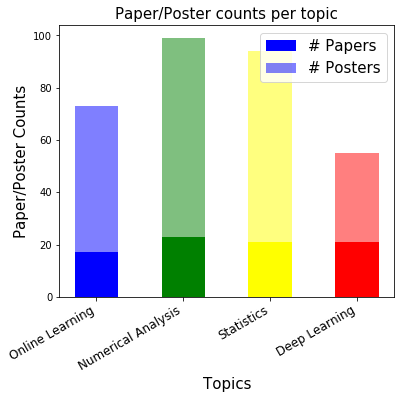

In [238]:
pap_cnts = {i:len(p_df[(p_df['clusters']==i) & (~filter)]) for i in range(4)}
pos_cnts = {i:len(p_df[(p_df['clusters']==i) & (filter)]) for i in range(4)}

fig = figure(figsize=(6,5))

npap_ls = [pap_cnts[k] for k in range(4)]
npos_ls = [pos_cnts[k] for k in range(4)]
cols = [cluster_colors[i] for i in range(4)]

bar(range(4), npap_ls, align='center', width=0.5, color=cols , alpha=1.0, label='# Papers')
bar(range(4), npos_ls, align='center', width=0.5, color=cols, alpha=0.5, label='# Posters')

xticks(range(4), [top_labels[k] for k in range(4)], rotation=30, ha= 'right', fontsize=12)

title('Paper/Poster counts per topic', fontsize=15)
xlabel('Topics', fontsize=15); ylabel('Paper/Poster Counts', fontsize=15);

legend(loc='upper right', fontsize=15); show();

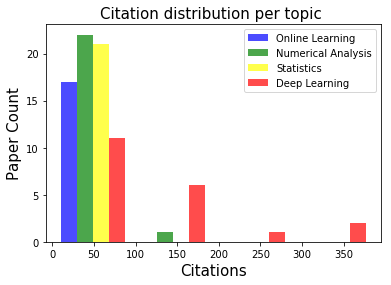

In [163]:
fig = figure(figsize=(6,4))
bins = np.linspace(1, p_df['Citations'].max(), 5)

vals = {i:p_df[(p_df['clusters']==i) & (~filter)]['Citations'].tolist() for i in range(4)}
    
hist([vals[i] for i in range(4)], bins,\
     color=[cluster_colors[i] for i in range(4)], alpha = 0.7,\
     label=[top_labels[i] for i in range(4)])
title('Citation distribution per topic ', fontsize=15)
xlabel('Citations', fontsize=15); ylabel('Paper Count', fontsize=15);
legend(loc='best');

The most cited papers belong to the __Deep learning__, which confirms our observation from the t-sne visualization.